In [1]:
# ставим facenet_pytorch откуда возьмем модель для детекции
!pip -q install facenet-pytorch --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.7 MB/s eta 0:00:0000:0100:01


In [2]:
# импортируем все что нужно
import sys
import torch
from pathlib import Path

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from facenet_pytorch import MTCNN
import glob
import pandas as pd

import torchvision.transforms as T
import torch.nn.functional as F

In [3]:
data_path = Path("/kaggle/input/data-for-pipeline")
sys.path.insert(0, str(data_path))  

In [4]:
# импортируем пайплайн
from pipeline import FacePipeline


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
hg_ckpt = data_path / "best_stacked_hg.pth"
af_ckpt = data_path / "best_af.pth"

pipe = FacePipeline(hg_ckpt, af_ckpt, device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 198MB/s] 


In [7]:
# будем тренироваться на дагестанцах 
images_path = data_path = Path("/kaggle/input/images-to-test-pipeline")

In [8]:
# выбираем референс картинку и находим ембеддинг для нее
ref_path = images_path / "islam0.png"  
ref_img = Image.open(ref_path).convert("RGB")

ref_faces = pipe.infer(ref_img, margin=-0.05, det_thr=0.90)
ref_emb = ref_faces[0]["embedding"]


In [9]:
# считаем cosine similarity
def cosine_sim(a, b):

    a = np.array(a)
    b = np.array(b)

    dot = np.dot(a, b)

    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)

    sim = dot / (norm_a * norm_b)
    return float(sim)

# обрезаем картинку по лицу
def crop_box(img_pil, box):

    width, height = img_pil.size

    # координаты bbox
    x1, y1, x2, y2 = box
    x1 = int(round(x1))
    y1 = int(round(y1))
    x2 = int(round(x2))
    y2 = int(round(y2))

    # не выходим за границы изображения
    if x1 < 0:
        x1 = 0
    if y1 < 0:
        y1 = 0
    if x2 > width:
        x2 = width
    if y2 > height:
        y2 = height

    # вырезаем участок изображения
    cropped = img_pil.crop((x1, y1, x2, y2))
    return cropped


In [10]:
# теперь пробежимся по остальным картинкам и посчитаем эмбеддинги для лиц на них и cosine similarity c реферонсом

image_paths = glob.glob('/kaggle/input/images-to-test-pipeline/*')
image_paths = [path for path in image_paths if 'islam0' not in path]

results = []

for path in image_paths:
    img = Image.open(path).convert("RGB")
    faces = pipe.infer(img, margin=-0.05, det_thr=0.90)

    face_list = []
    for f in faces:
        sim = cosine_sim(f["embedding"], ref_emb)
        face_list.append({
            "sim": sim,
            "crop": crop_box(img, f["box"])
        })

    # сортируем лица по убыванию similarity
    face_list.sort(key=lambda x: x["sim"], reverse=True)

    best_sim = face_list[0]["sim"] 

    results.append({
        "path": path,
        "img": img,
        "faces": face_list,
        "best_sim": best_sim
    })

#сортируем картинки по убыванию similarity
results.sort(key=lambda x: x["best_sim"], reverse=True)

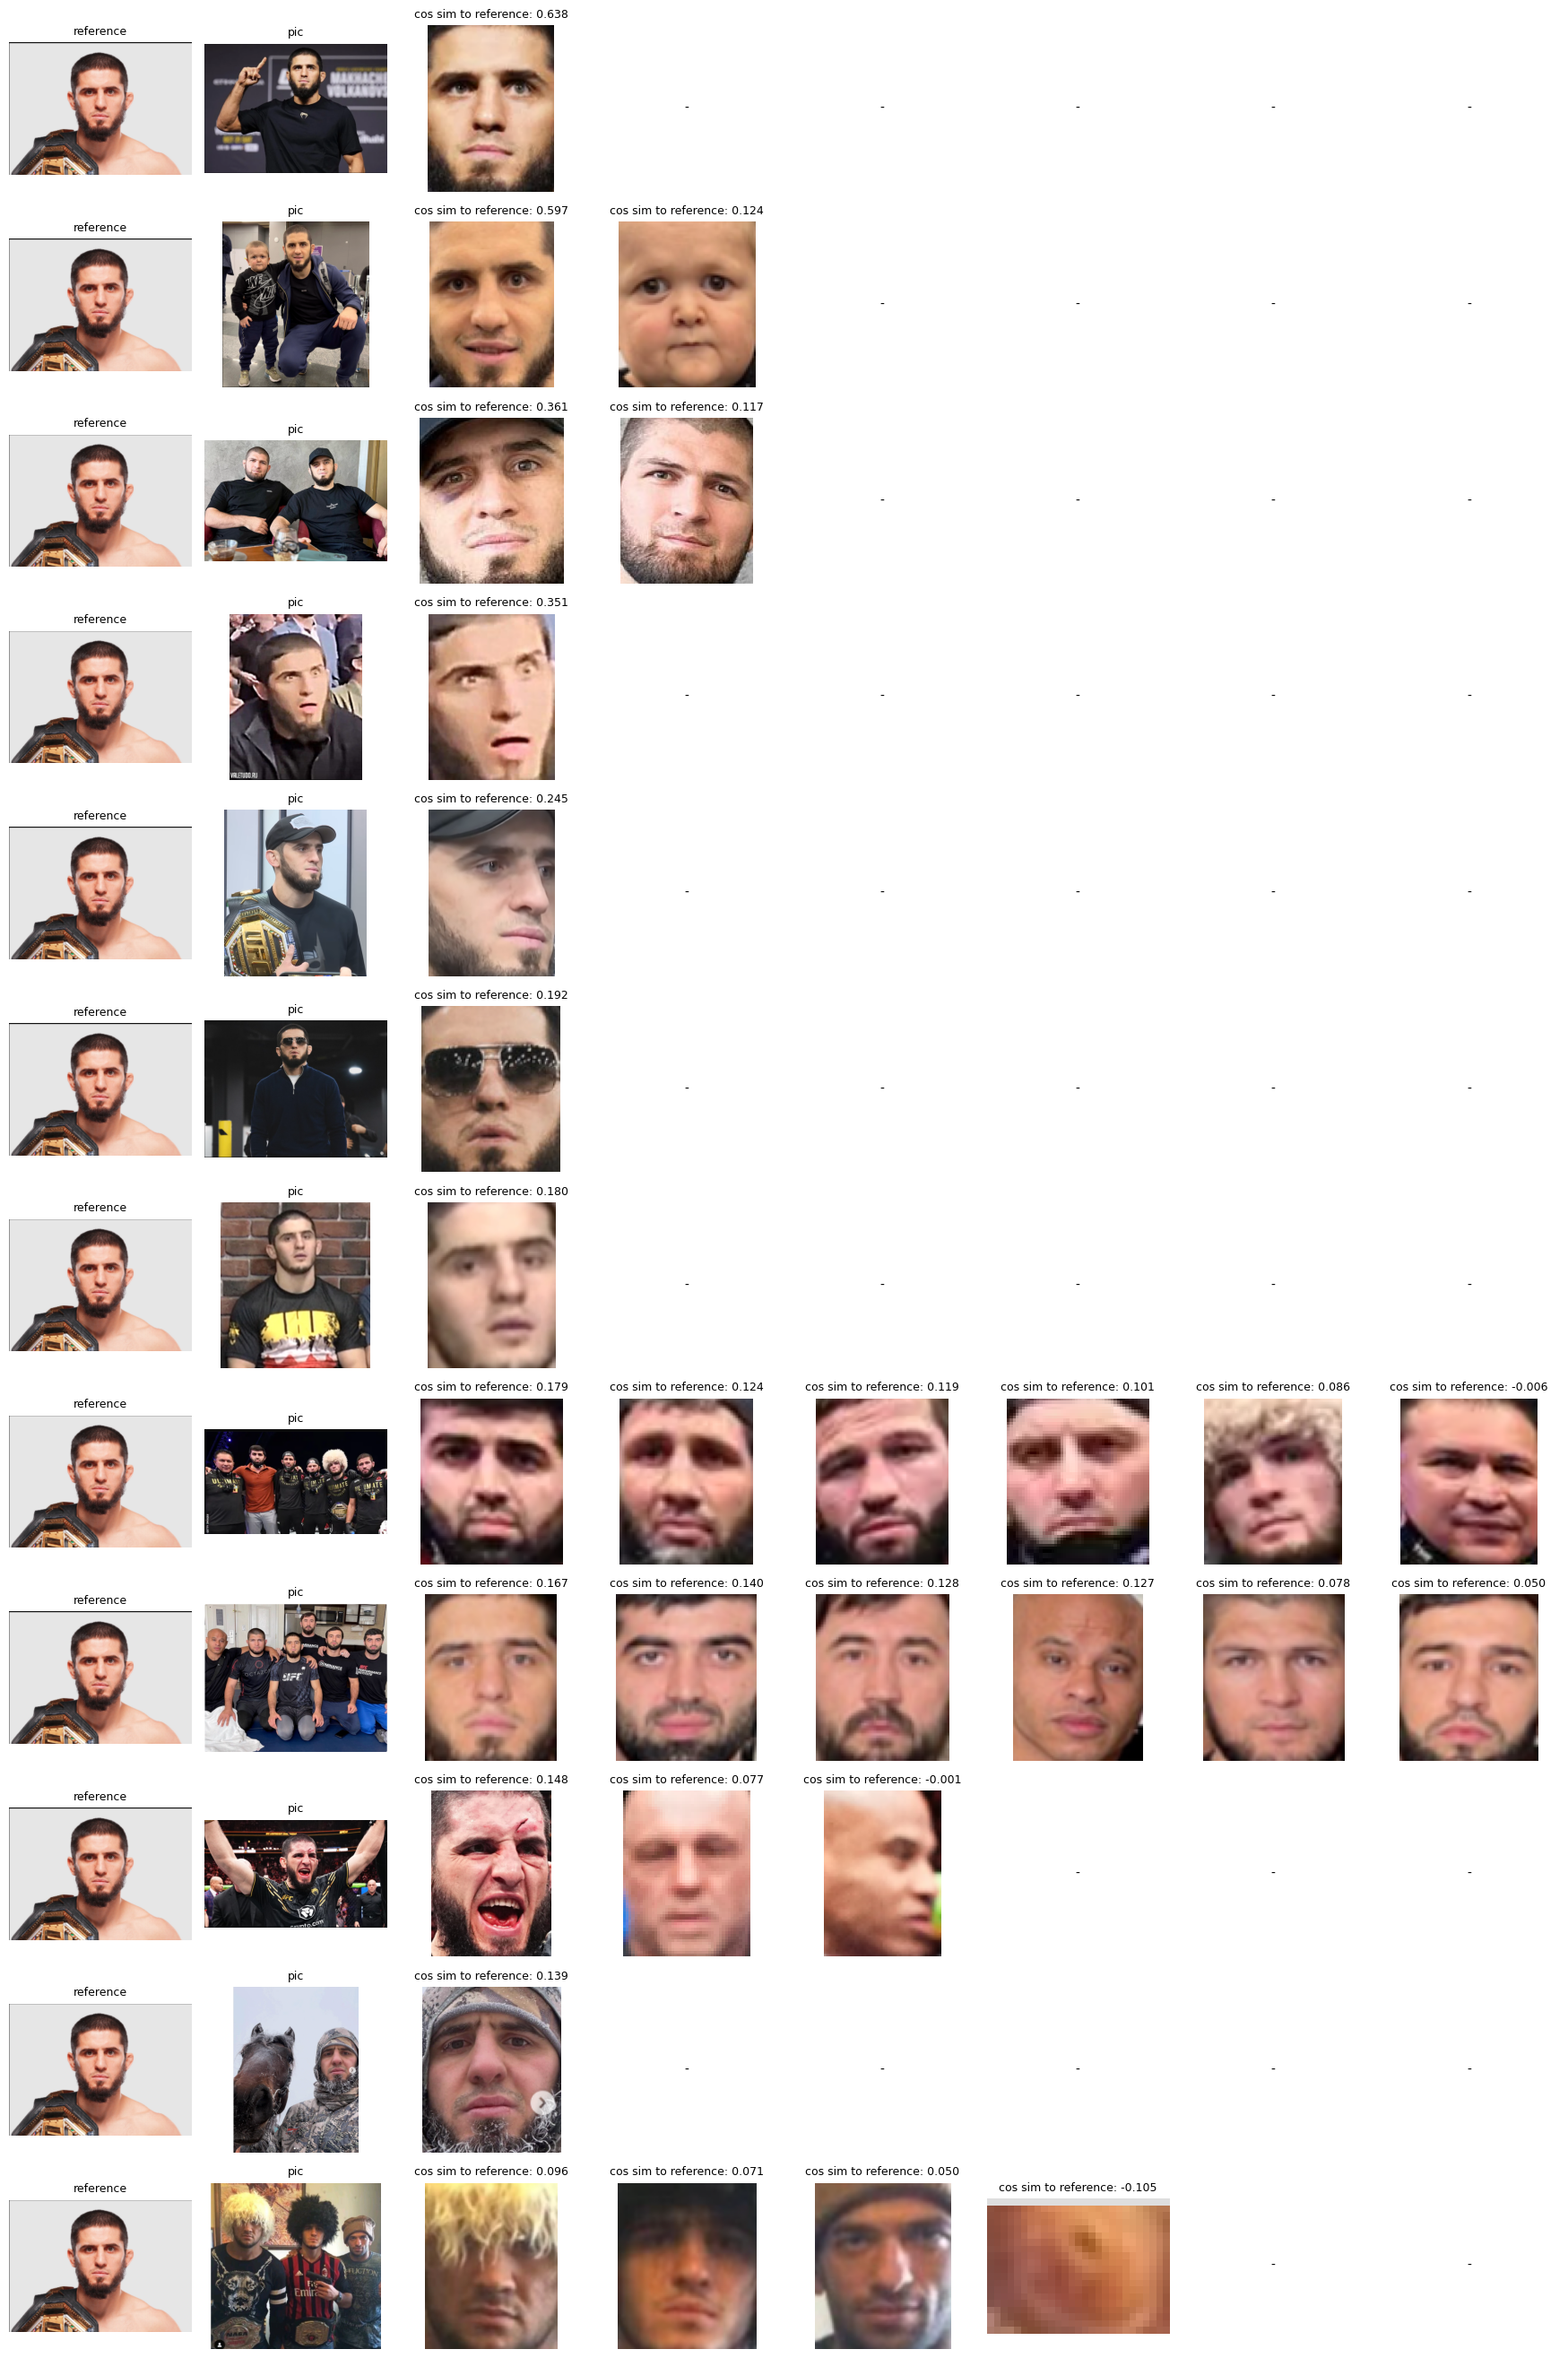

In [12]:
max_images = 25
max_faces_per_image = 6

rows = min(len(results), max_images)

cols = 2 + max_faces_per_image

plt.figure(figsize=(cols * 2.2, rows * 2.2))

for r in range(rows):
    item = results[r]

    # референс
    ax = plt.subplot(rows, cols, r * cols + 1)
    ax.imshow(ref_img)
    ax.set_title("reference", fontsize=9)
    ax.axis("off")

    # исходная картинка 
    ax = plt.subplot(rows, cols, r * cols + 2)
    ax.imshow(item["img"])
    ax.set_title("pic", fontsize=9)
    ax.axis("off")

    # лица отсортированный по similarity
    for c in range(max_faces_per_image):
        ax = plt.subplot(rows, cols, r * cols + 3 + c)

        if c < len(item["faces"]) and item["faces"][c]["crop"] is not None:
            ax.imshow(item["faces"][c]["crop"])
            ax.set_title(f"cos sim to reference: {item['faces'][c]['sim']:.3f}", fontsize=9)
        else:
            ax.text(0.5, 0.5, "-", ha="center", va="center")

        ax.axis("off")

plt.tight_layout()
plt.show()


на мой взгляд получилось неплохо :)